In [1]:
import json
import torch
import seaborn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
mat_dict = {}
path_lst = ['./results/kt_base_model.pth', './results/kt_pre_model.pth', 
            './results/ec+kt+mtl_model.pth', './results/ec+kt+e2e_model.pth']
key_list = ['base', 'pre', 'mtl', 'e2e', ]

In [13]:
for i, path in enumerate(path_lst):
    state = torch.load(path)
    try:
        mat = state['kt_net']['q_embed.weight'].t().cpu().numpy()
    except KeyError:
        mat = state['net']['q_embed.weight'].t().cpu().numpy()
    print("%s_matrix.shape" % key_list[i], mat.shape)
    mat_dict[key_list[i]] = mat.tolist()

base_matrix.shape (8, 128)
pre_matrix.shape (8, 128)
mtl_matrix.shape (8, 128)
e2e_matrix.shape (8, 128)


In [5]:
def cos_reduction(mat):
    pro = np.matmul(mat, mat.transpose())
    nor = np.linalg.norm(mat, ord=2, axis=1)
    cos = pro / nor / nor.transpose()
    return cos

In [6]:
def coo_reduction(itm_lst, exe_lst=None):
    coo = np.array([[0] * 8] * 8)
    tot = np.array([0] * 8).reshape(-1, 1)
    exe_lst = [1] * 1500 if exe_lst is None else exe_lst
    for idx, itm in enumerate(itm_lst):
        cls = np.array(itm['class']).reshape(-1, 1)
        tot += cls * exe_lst[idx]
        cls = np.matmul(cls, cls.transpose())
        coo += cls * exe_lst[idx]
    coo = coo.tolist()
    tot = tot.reshape(-1).tolist()
    for idx in range(8):
        for jdx in range(8):
            coo[idx][jdx] /= tot[idx]
    return np.array(coo)

In [7]:
with open('./ec_train_data.json', 'r', encoding='utf8') as train_data:
    train_geo = json.load(train_data)
with open('./ec_test_data.json', 'r', encoding='utf8') as test_data:
    test_geo = json.load(test_data)
    total_geo = train_geo + test_geo

In [8]:
exe_dct = [0] * 1500
f_data = open('./exercise_data_b.txt', 'r')
for lineID, line in enumerate(f_data):
    line = '[' + line.strip() + ']'
    if lineID % 4 == 1:
        pro_s = eval(line)
        for pid in pro_s:
            exe_dct[pid] += 1
f_data.close()

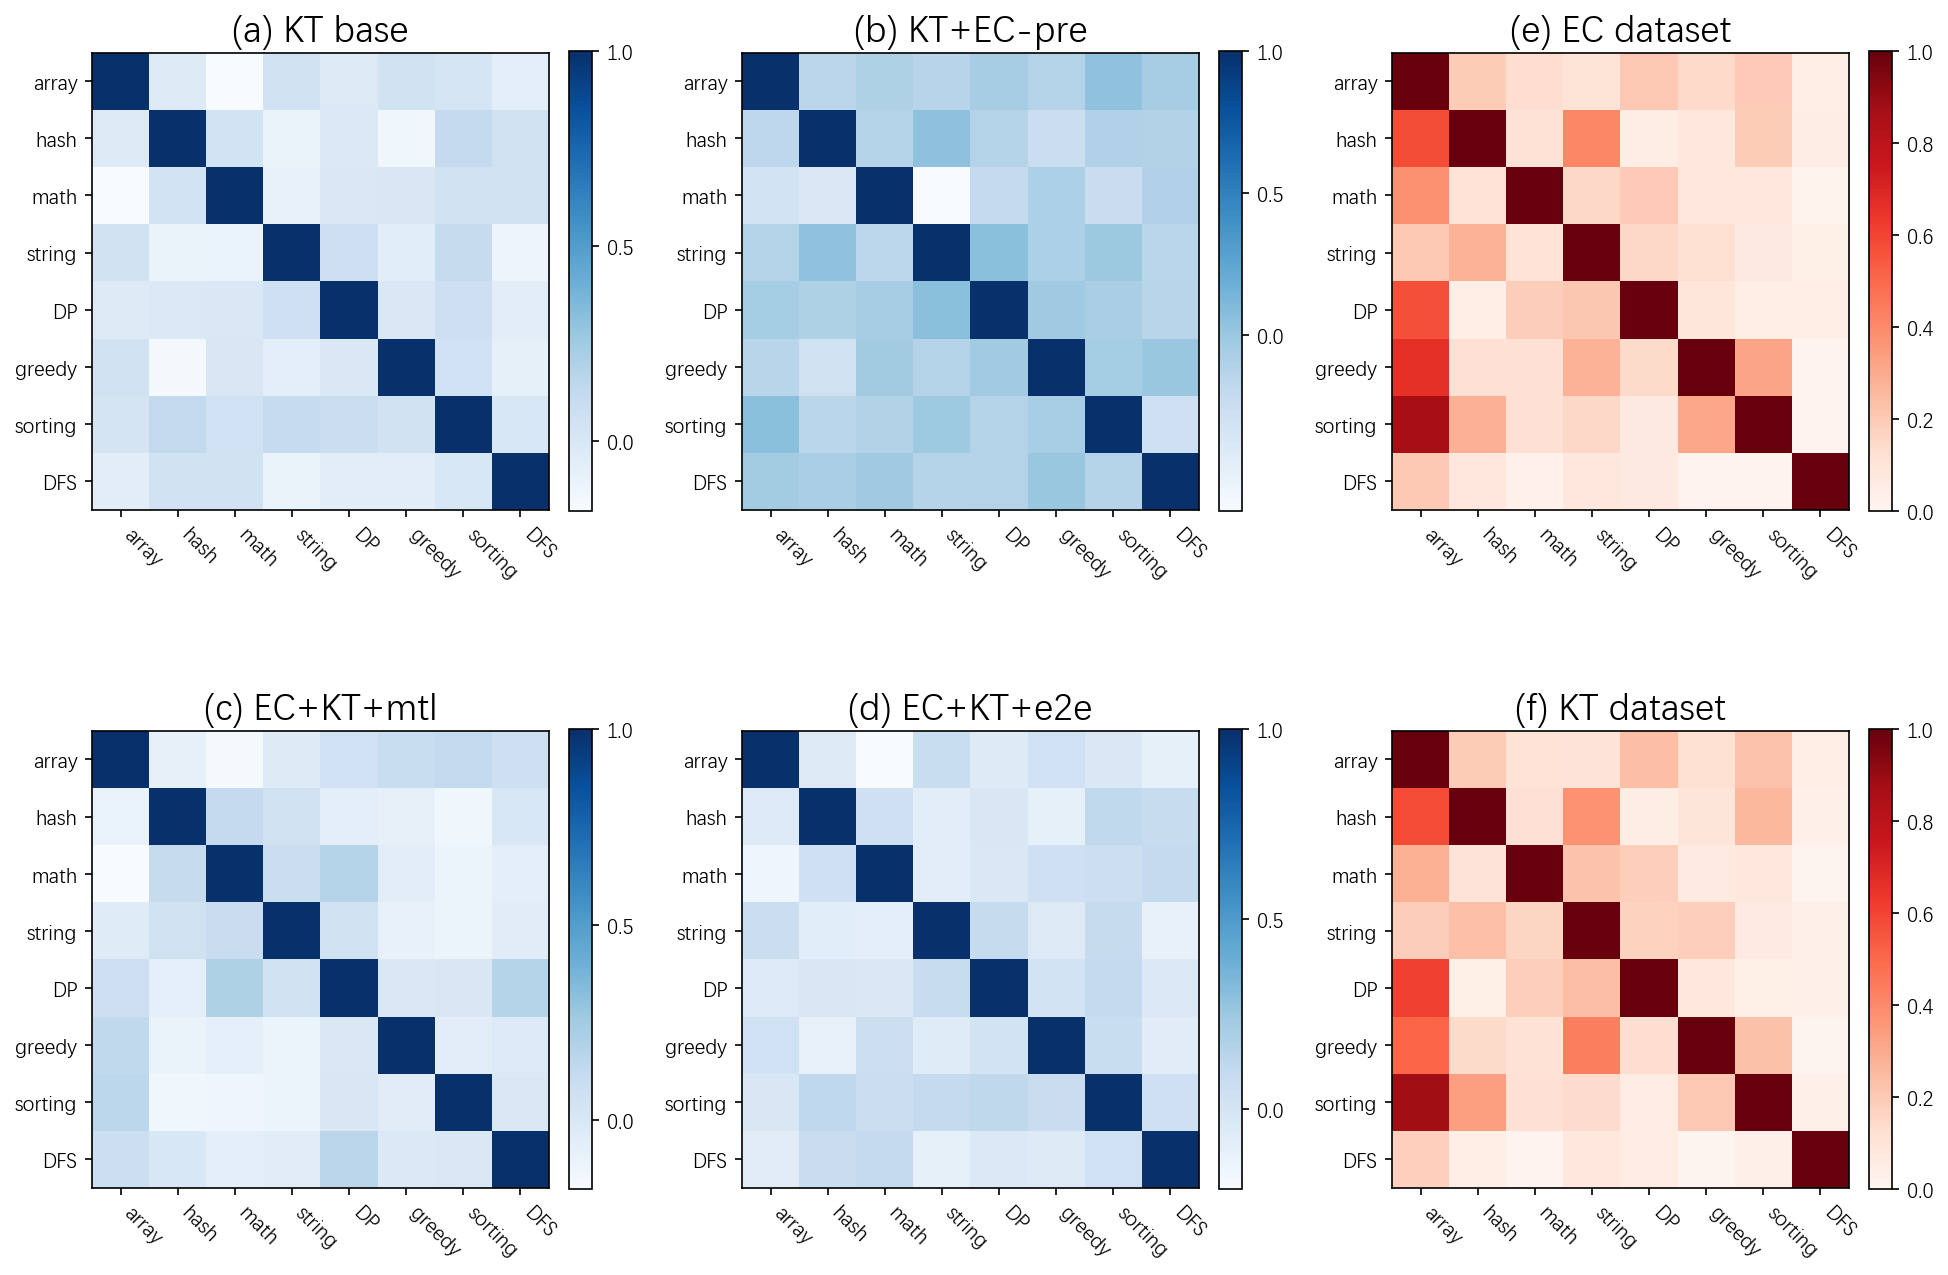

In [14]:
fig = plt.figure(num=1, figsize=(15, 10), dpi=150, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
lbl_list = ['array', 'hash', 'math', 'string', 'DP', 'greedy', 'sorting', 'DFS']
ttl_list = ['(a) KT base', '(b) KT+EC-pre', '(c) EC+KT+mtl', '(d) EC+KT+e2e', '(e) EC dataset', '(f) KT dataset',]
mat_list = [np.array(mat_dict[key]) for key in key_list]

for i in range(4):
    idx = 1 + i % 2 + 3 * (i // 2)
    axe = fig.add_subplot(2, 3, idx)
    cos_mat = cos_reduction(mat_list[i])
    img = axe.imshow(cos_mat, interpolation='nearest', cmap=plt.cm.Blues)
    axe.set_xticks(range(len(lbl_list)))
    axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
    axe.set_yticks(range(len(lbl_list)))
    axe.set_yticklabels(lbl_list)
    axe.set_title(ttl_list[i], fontsize=18)
    plt.colorbar(img, ticks=[0, 0.5, 1], fraction=0.046, pad=0.04)

axe = fig.add_subplot(2, 3, 3)
coo_mat = coo_reduction(total_geo)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[-2], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

axe = fig.add_subplot(2, 3, 6)
coo_mat = coo_reduction(total_geo, exe_dct)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[-1], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

plt.savefig('./results/cmp_kt/cmp_kt_mat_con.jpg')
plt.show()